In [394]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn import metrics
from datetime import date

# import modelling from sklearn
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.grid_search import GridSearchCV
from sklearn.cross_validation import cross_val_score
from sklearn.tree import export_graphviz
from sklearn.cross_validation import train_test_split

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

In [395]:
# From Kaggle Competition. Expedia Hotel Recommendations
# https://www.kaggle.com/c/expedia-hotel-recommendations

## Load the data from expedia kaggle Challenge
destinations = pd.read_csv('../Final_Project/data/destinations.csv') 
# Read data into pandas and explore
# expedia = pd.read_csv('../Final_Project/data/train.csv') # takes a LONG time to load the full dataset! 
expedia = pd.read_csv('../Final_Project/data/train.csv',nrows=5000) # test code with smaller set first for faster code check. 
# other dataset provided: testing dataset
# df_test = pd.read_csv('../Final_Project/data/test.csv'); # will read this is later when/if needed. 

In [396]:
print 'Expedia Site Dataframe Shape'
print expedia.shape
expedia.head(2)
print 'Destinations Dataframe Shape'
print destinations.shape
destinations.head(2)

Expedia Site Dataframe Shape
(5000, 24)
Destinations Dataframe Shape
(62106, 150)


,srch_destination_id,d1,d2,d3,d4,d5,d6,d7,d8,d9,...,d140,d141,d142,d143,d144,d145,d146,d147,d148,d149
0,0,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-1.897627,-2.198657,-2.198657,-1.897627,...,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657
1,1,-2.181690,-2.181690,-2.181690,-2.082564,-2.181690,-2.165028,-2.181690,-2.181690,-2.031597,...,-2.165028,-2.181690,-2.165028,-2.181690,-2.181690,-2.165028,-2.181690,-2.181690,-2.181690,-2.181690


Explaination of Columns from https://www.kaggle.com/c/expedia-hotel-recommendations/data 

date_time - Timestamp - string
site_name - ID of the Expedia point of sale - int
posa_continent - ID of continent associated with site_name	- int
user_location_country - The ID of the country the customer is located - int
user_location_region - The ID of the region the customer is located - int
user_location_city - The ID of the city the customer is located - int
orig_destination_distance - Physical distance between a hotel and a customer at the time of search. A null means the distance could not be calculated- double
user_id - ID of user - int
is_mobile - 1 when a user connected from a mobile device, 0 otherwise - tinyint
is_package - 1 if the click/booking was generated as a part of a package, 0 otherwise - int
channel  - 	ID of a marketing channel
srch_ci - Checkin date - string
srch_co - Checkout date - string
srch_adults_cnt - The number of adults specified in the hotel room - int
srch_children_cnt - The number of (extra occupancy) children specified in the hotel room - int
srch_rm_cnt - The number of hotel rooms specified in the search - int
srch_destination_id - ID of the destination where the hotel search was performed - int
srch_destination_type_id - Type of destination - int
hotel_continent - Hotel continent - int
hotel_country - Hotel country - int
hotel_market - Hotel market - int
is_booking - 1 if a booking, 0 if a click - tinyint
cnt - Numer of similar events in the context of the same user session  -bigint
hotel_cluster - ID of a hotel cluster - int

In [397]:
# Print some info about dataset

# user IDs. 
print 'Dataset Stats'
print 'Size of Dataframe', expedia.shape

# unique User counts. 
user = expedia.groupby('user_id').user_id.count()
muser = user.mean()
print 'Unique Users: ', len(user)
print 'Mean entries per user: ', muser

# Number of bookings vs. other entries. 
lbook = len(expedia.loc[(expedia['is_booking']  == 1)])
num_book = expedia.groupby('is_booking').is_booking.count()
print 'Number of entries where users book', lbook, 'total', len(expedia)

# unique hotel cluster counts. 
hc = expedia.groupby('hotel_cluster').hotel_cluster.count()
print 'Unique Hotel Cluter IDs: ', len(hc)

Dataset Stats
Size of Dataframe (5000, 24)
Unique Users:  177
Mean entries per user:  28.2485875706
Number of entries where users book 393 total 5000
Unique Hotel Cluter IDs:  100


In [398]:
# Prep Expedia Train Dataset 
# Add a column for the epoch time to dataset. 
# Need to do this before time is changed from a string to a date time
import time, os
# search time epoch
epochs = []
d = expedia.date_time
p='%Y-%m-%d %H:%M:%S'
for dts in d:
    epoch = int(time.mktime(time.strptime(dts,p)))
    epochs.append(epoch)
expedia['search_time_epoch'] = epochs

# time on site column
# using time the user first searched as t0. i.e. 0 time = first search
expedia['tos'] = expedia.search_time_epoch
user = expedia.user_id
for u in user: 
    t0 = min(expedia.loc[expedia.user_id == u].search_time_epoch)
    expedia.loc[expedia['user_id']==u,'tos'] = expedia.search_time_epoch - t0

# check-in time epoch
# Do not have hh:mm:ss for check in and out. 
# Using 4:00 pm as default for checkout
# epochs = []
# d = expedia.srch_ci
# p='%Y-%m-%d %H:%M:%S'
# for dts in d:
#    epoch = int(time.mktime(time.strptime(dts,p)))
#    epochs.append(epoch)
# expedia['srch_ci_epoch'] = epochs

# check-out time epoch
# Using 11:59 am as default for checkout
# epochs = []
# d = expedia.srch_co
# p='%Y-%m-%d %H:%M:%S'
# for dts in d:
#    epoch = int(time.mktime(time.strptime(dts,p)))
#    epochs.append(epoch)
# expedia['srch_co_epoch'] = epochs

expedia.head(2)

,date_time,site_name,posa_continent,user_location_country,user_location_region,user_location_city,orig_destination_distance,user_id,is_mobile,is_package,...,srch_destination_id,srch_destination_type_id,is_booking,cnt,hotel_continent,hotel_country,hotel_market,hotel_cluster,search_time_epoch,tos
0,2014-08-11 07:46:59,2,3,66,348,48862,2234.2641,12,0,1,...,8250,1,0,3,2,50,628,1,1407768419,0
1,2014-08-11 08:22:12,2,3,66,348,48862,2234.2641,12,0,1,...,8250,1,1,1,2,50,628,1,1407770532,2113


In [399]:
# define function to find the day of the week. 
# Monday = 1, Sunday = 7
def find_dow(date_col):
    dow = []
    for d in date_col: 
        dow.append(d.isoweekday()) 
    return dow

In [400]:
# Adding Time Feature columns to Dataset 

# Replacing NaN/None values in check in and out search. 
expedia['srch_ci'] = np.where(pd.isnull(expedia.srch_ci) == 1, 0, expedia.srch_ci)
expedia['srch_co'] = np.where(pd.isnull(expedia.srch_co) == 1, 0, expedia.srch_co)

expedia['date_time'] = pd.to_datetime(expedia['date_time'])
expedia['year'] = expedia['date_time'].dt.year
expedia['month'] = expedia['date_time'].dt.month
expedia['day'] = expedia['date_time'].dt.day

# -------------------
# Adding Day of the week the search occured
# Monday = 1, Sunday = 7
date_time = expedia.date_time
dow = find_dow(date_time)
expedia['dow_search'] = dow

# -------------------
# Adding Day of the week check-in date
expedia['srch_ci'] = pd.to_datetime(expedia['srch_ci'])
date_ci = expedia.srch_ci
dow = find_dow(date_ci)
expedia['dow_ci'] = dow

# -------------------
# Adding Day of the week check-out date
expedia['srch_co'] = pd.to_datetime(expedia['srch_co'])
date_co = expedia.srch_co
dow = find_dow(date_co)
expedia['dow_co'] = dow

# -------------------
# length of stay in days
delta = date_co - date_ci
los = np.zeros(len(delta))
c = 0
for d in date_ci:
    los[c] = delta[c].days
    c += 1    
expedia['length_of_stay'] = los

# -------------------
# Adding a feature that guesses if it is a  business_trip. (questionable column)
# definition: checkin Sunday(7) - Thursday(4) and must check out same week Monday(!) - Friday(5). 
# 1 = weekend, 0 = during week trip. 
# los = expedia.length_of_stay
dow_ci = expedia.dow_ci
dow_co = expedia.dow_co
bt = np.zeros(len(dow_ci))
c = 0;
for ci in dow_ci:
    # if check in sunday - Check that check out is Monday - Friday of the same week
    if ci == 7:
        if los[c] < 5 and dow_co[c] < 6:
            bt[c] = 1
    elif ci < 4:
        if los[c] < 5 and dow_co[c] <= 5:
            bt[c] = 1
    c += 1
expedia['is_business_trip'] = bt 
expedia


expedia.head(2)

,date_time,site_name,posa_continent,user_location_country,user_location_region,user_location_city,orig_destination_distance,user_id,is_mobile,is_package,...,search_time_epoch,tos,year,month,day,dow_search,dow_ci,dow_co,length_of_stay,is_business_trip
0,2014-08-11 07:46:59,2,3,66,348,48862,2234.2641,12,0,1,...,1407768419,0,2014,8,11,1,3,7,4.0,0.0
1,2014-08-11 08:22:12,2,3,66,348,48862,2234.2641,12,0,1,...,1407770532,2113,2014,8,11,1,5,2,4.0,0.0


 feature ideas: 
 number or clicks before purchase
 repeat clicks? user visits same hotel cluster again 
 
 if user books more than one hotel - is it in the same cluster, same location? 
 time on site searching column (from time_epoch)
 
 add dictionary look up for user.
 Recommendation engine? 

In [401]:
# Adding feature columns to dataset. 

# if there are children - making a binary column of family
is_family = np.where(expedia.srch_children_cnt >= 1, 1, 0)
expedia['is_family'] = is_family

# Adding column for search and is booking. 
# booking cluster  = 100 + cluster ID if booked,  0 if not booking
expedia['booking_clust'] = np.where(expedia.is_booking == 1,(100+ expedia.hotel_cluster) ,0)

expedia.head(2)

,date_time,site_name,posa_continent,user_location_country,user_location_region,user_location_city,orig_destination_distance,user_id,is_mobile,is_package,...,year,month,day,dow_search,dow_ci,dow_co,length_of_stay,is_business_trip,is_family,booking_clust
0,2014-08-11 07:46:59,2,3,66,348,48862,2234.2641,12,0,1,...,2014,8,11,1,3,7,4.0,0.0,0,0
1,2014-08-11 08:22:12,2,3,66,348,48862,2234.2641,12,0,1,...,2014,8,11,1,5,2,4.0,0.0,0,101


In [402]:
# Prep Destinations Dataset
# Adding Mean, Meadian, stdev, is_positive columns 
d = destinations
d = d.drop('srch_destination_id',axis = 1)

destinations['mean_latent'] = np.nanmean(d, axis=1)
destinations['median_latent'] = np.nanmedian(d, axis=1)
destinations['std_latent'] = np.nanstd(destinations, axis=1)
destinations['mean_p_std_latent'] = abs(destinations.mean_latent) + destinations.std_latent
destinations['max_latent'] = np.nanmax(d, axis=1)
destinations['min_latent'] = np.nanmin(d, axis=1)
destinations['is_positive_review'] = np.where(destinations.mean_latent > 0, 1, 0)
destinations['range_latent'] = destinations.max_latent - destinations.min_latent

# use only summary columns in training. 
use = ['srch_destination_id', 'mean_latent', 'median_latent', 'std_latent',\
       'mean_p_std_latent', 'max_latent', 'min_latent','is_positive_review',\
       'range_latent']
destinations_use =  destinations[use]

print destinations.shape
print destinations_use.shape
print destinations_use.isnull().sum()
destinations_use.head(5)

(62106, 158)
(62106, 9)
srch_destination_id    0
mean_latent            0
median_latent          0
std_latent             0
mean_p_std_latent      0
max_latent             0
min_latent             0
is_positive_review     0
range_latent           0
dtype: int64


,srch_destination_id,mean_latent,median_latent,std_latent,mean_p_std_latent,max_latent,min_latent,is_positive_review,range_latent
0,0,-2.180474,-2.198657,0.190054,2.370529,-1.897627,-2.198657,0,0.301030
1,1,-2.173926,-2.181690,0.257733,2.431660,-2.031597,-2.181690,0,0.150093
2,2,-2.179064,-2.224164,0.344545,2.523609,-1.903782,-2.224164,0,0.320382
3,3,-2.173419,-2.177409,0.418466,2.591885,-2.101291,-2.177409,0,0.076118
4,4,-2.175013,-2.191779,0.500622,2.675635,-1.946523,-2.194008,0,0.247485


In [403]:
# Add Destination Data Information to Expedia Dataset
# Adding by search destination ID

# print expedia.shape
# print destinations_use.shape
expedia = pd.merge(expedia, destinations_use, left_on='srch_destination_id', \
                   right_on='srch_destination_id', how='left')

print expedia.shape
expedia.head(2)

(5000, 44)


,date_time,site_name,posa_continent,user_location_country,user_location_region,user_location_city,orig_destination_distance,user_id,is_mobile,is_package,...,is_family,booking_clust,mean_latent,median_latent,std_latent,mean_p_std_latent,max_latent,min_latent,is_positive_review,range_latent
0,2014-08-11 07:46:59,2,3,66,348,48862,2234.2641,12,0,1,...,0,0,-2.282679,-2.381387,667.143168,669.425846,-1.140066,-2.400912,0.0,1.260846
1,2014-08-11 08:22:12,2,3,66,348,48862,2234.2641,12,0,1,...,0,101,-2.282679,-2.381387,667.143168,669.425846,-1.140066,-2.400912,0.0,1.260846


In [404]:
# fix NaN and Null values
expedia['mean_latent'] = np.where(pd.isnull(expedia.mean_latent) == 1, 0, expedia.mean_latent)
expedia['median_latent'] = np.where(pd.isnull(expedia.median_latent) == 1, 0, expedia.median_latent)
expedia['std_latent'] = np.where(pd.isnull(expedia.std_latent) == 1, 0, expedia.std_latent)
expedia['mean_p_std_latent'] = np.where(pd.isnull(expedia.mean_p_std_latent) == 1, 0, expedia.mean_p_std_latent)
expedia['max_latent'] = np.where(pd.isnull(expedia.max_latent) == 1, 0, expedia.max_latent)
expedia['min_latent'] = np.where(pd.isnull(expedia.min_latent) == 1, 0, expedia.min_latent)
expedia['is_positive_review'] = np.where(pd.isnull(expedia.is_positive_review) == 1, 0, expedia.is_positive_review)
expedia['range_latent'] = np.where(pd.isnull(expedia.range_latent) == 1, 0, expedia.range_latent)

# some features have negative values. making abs(features) for NB  
expedia['abs_mean_latent'] = expedia['mean_latent'].abs()
expedia['abs_median_latent'] = expedia['median_latent'].abs()
expedia['abs_max_latent'] = expedia['max_latent'].abs()
expedia['abs_min_latent'] = expedia['min_latent'].abs()

In [405]:
print expedia.isnull().sum()
print expedia.columns

date_time                       0
site_name                       0
posa_continent                  0
user_location_country           0
user_location_region            0
user_location_city              0
orig_destination_distance    2131
user_id                         0
is_mobile                       0
is_package                      0
channel                         0
srch_ci                         0
srch_co                         0
srch_adults_cnt                 0
srch_children_cnt               0
srch_rm_cnt                     0
srch_destination_id             0
srch_destination_type_id        0
is_booking                      0
cnt                             0
hotel_continent                 0
hotel_country                   0
hotel_market                    0
hotel_cluster                   0
search_time_epoch               0
tos                             0
year                            0
month                           0
day                             0
dow_search    

In [406]:
# Predict if a person is booking or not.  DO NOT NEED TO DO THIS
# We do not care what hotel cluster a person is looking at unless they book. 

# print expedia.hotel_cluster.max()
# print expedia.hotel_cluster.min()
# expedia.corr()

# labels = expedia.columns # features to train with 
# full list
# X = ['date_time', u'site_name', u'posa_continent', u'user_location_country',
#       'user_location_region', 'user_location_city',
#        'orig_destination_distance', 'user_id', 'is_mobile', u'is_package',
#        'channel', 'srch_ci', 'srch_co', 'srch_adults_cnt',
#        'srch_children_cnt', 'srch_rm_cnt', 'srch_destination_id',
#        'srch_destination_type_id', 'is_booking', u'cnt', u'hotel_continent',
#        'hotel_country', 'hotel_market', 'hotel_cluster',
#        'search_time_epoch', 'tos', 'year', 'month', 'day', 'dow_search',
#       'dow_ci', 'dow_co', 'length_of_stay', 'is_business_trip',
#       'is_family', 'booking_clust', 'mean_latent_x', 'median_latent_x',
#       'std_latent_x', 'mean_p_std_latent_x', 'max_latent_x',
#       'min_latent_x', 'is_positive_review_x', 'range_latent_x',
#       'mean_latent_y', 'median_latent_y', 'std_latent_y',
#       'mean_p_std_latent_y', 'max_latent_y', 'min_latent_y',
#       'is_positive_review_y', 'range_latent_y', 'abs_mean_latent',
#       'abs_median_latent', 'abs_max_latent','abs_min_latent']
        
# ignore = ['is_booking','date_time','srch_ci','srch_co','orig_destination_distance']
# X = expedia.drop(ignore, axis = 1) # features
# feature_cols = X.columns # get colnames for use later
# np.array(expedia) 
# target = expedia.is_booking # y 

In [407]:
# add a null model for comparison of baseline 
# 1 - expedia.is_booking.mean()


In [408]:
# train a classification model with existing columns
# trying KNN and log reg to start. 
# Note: do not need to test_train_split because Kaggle provides a separate traing set. 

# knn
# k = 3
# knn = KNeighborsClassifier(n_neighbors=k)
# knn.fit(X, target)
# knn.score(X, target)


# k_range = range(2, 30, 1)
# param_grid = dict(n_neighbors=k_range)
# grid = GridSearchCV(knn, param_grid, cv=5, scoring='accuracy')
# grid.fit(X_train, y_train)
# grid.grid_scores_
# grid_mean_scores = [result[1] for result in grid.grid_scores_] # get scores from grid.grid_scores_
# visualize results
# plt.figure()
# plt.plot(k_range, grid_mean_scores)

# retraining with added column
# knn

# k = 3
# knn = KNeighborsClassifier(n_neighbors=k)
# knn.fit(X, target)
# knn.score(X, target)
# preds_knn = knn.predict(X)
# print 'Accuracy for KNN model'
# print accuracy_score(target, preds_knn)
# print 'KNN Confusion Matrix'
# print metrics.confusion_matrix(target, preds_knn)
# target_names = ['Did not Book 0','Booked 1']
# print(classification_report(target, preds_knn, target_names=target_names))

# test set 
# preds_knn = knn.predict(X_test)
# print 'Accuracy for KNN model'
# print accuracy_score(y_test, preds_knn)
# print 'KNN Confusion Matrix'
# print metrics.confusion_matrix(y_test, preds_knn)
# print(classification_report(y_test, preds_knn, target_names=target_names))


In [409]:
# LogReg
# logreg = LogisticRegression(C=1e9)
# logreg.fit(X, target)
# assorted_pred_class = logreg.predict(X)
# logregm = zip(feature_cols,logreg.coef_[0])
# preds_logreg = logreg.predict(X)
# print 'Accuracy for Logistic Regression model'
# print accuracy_score(target, preds_logreg)
# print 'Logistic Regression Confusion Matrix'
# print metrics.confusion_matrix(target, preds_logreg)
# print(classification_report(target, preds_logreg, target_names=target_names))

Predicting which cluster the user will book.  
Assuming We know they are booking at the moment. 

In [410]:
# For predicting which hotel cluster the person will book. 

# X = ['date_time', u'site_name', u'posa_continent', u'user_location_country',
#       'user_location_region', 'user_location_city',
#        'orig_destination_distance', 'user_id', 'is_mobile', u'is_package',
#        'channel', 'srch_ci', 'srch_co', 'srch_adults_cnt',
#        'srch_children_cnt', 'srch_rm_cnt', 'srch_destination_id',
#        'srch_destination_type_id', 'is_booking', u'cnt', u'hotel_continent',
#        'hotel_country', 'hotel_market', 'hotel_cluster',
#        'search_time_epoch', 'tos', 'year', 'month', 'day', 'dow_search',
#       'dow_ci', 'dow_co', 'length_of_stay', 'is_business_trip',
#       'is_family', 'booking_clust', 'mean_latent_x', 'median_latent_x',
#       'std_latent_x', 'mean_p_std_latent_x', 'max_latent_x',
#       'min_latent_x', 'is_positive_review_x', 'range_latent_x',
#       'mean_latent_y', 'median_latent_y', 'std_latent_y',
#       'mean_p_std_latent_y', 'max_latent_y', 'min_latent_y',
#       'is_positive_review_y', 'range_latent_y']

features = ['site_name', 'posa_continent', 'user_location_country',\
            'user_location_region', 'user_location_city',\
            'user_id', 'is_mobile', 'is_package',\
            'channel', 'srch_adults_cnt',\
            'srch_children_cnt', 'srch_rm_cnt', 'srch_destination_id',\
            'srch_destination_type_id', 'cnt', 'hotel_continent',\
            'hotel_country', 'hotel_market', 'hotel_cluster',\
            'search_time_epoch', 'tos', 'year', 'month', 'day', 'dow_search',\
            'dow_ci', 'dow_co', 'length_of_stay', 'is_business_trip',\
            'is_family', 'mean_latent', 'median_latent',\
            'std_latent', 'mean_p_std_latent', 'max_latent',\
            'min_latent', 'is_positive_review', 'range_latent',\
            'abs_mean_latent','abs_median_latent', 'abs_max_latent','abs_min_latent']

# Select df only when the user is booking the hotel. 
# only look at when a person is booking. 
df_book = expedia.loc[expedia.is_booking == 1]
print df_book.shape
# df_book.corr()

ignore = ['hotel_cluster', 'date_time', 'srch_ci', 'srch_co',\
          'booking_clust', 'orig_destination_distance']
X = df_book.drop(ignore, axis = 1) # features
target = df_book.hotel_cluster

(393, 48)


In [411]:
# Null model
# Compare your best RMSE on testing set with the RMSE for the "null model", which is the model that ignores
#   all features and simply predicts the mean rating in the training set for all observations in the testing set.

# Cross-Validation by
cvn = 10

predv = (df_book.hotel_cluster.mode()[0])
null_pred = np.ones(len(df_book.hotel_cluster)) * predv
df_book['prediction'] = null_pred
# y_train['prediction'] = np.ones(len(y_train.hotel_cluster)) * predv
# print df_book.isnull().sum()

# calculate RMSE for those predictions
rmse_null = np.sqrt(metrics.mean_squared_error(df_book.hotel_cluster, df_book.prediction))

# rmse_null_test = np.sqrt(metrics.mean_squared_error(y_test.hotel_cluster, y_train.prediction))
print 'Hypthesis Value: ', predv 
print 'Null Hypothesis RMSE: ', rmse_null


Hypthesis Value:  91
Null Hypothesis RMSE:  50.0759982223


/Users/mcullen/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


best grid score 0.0432569974555
Using K =  3
Accuracy for KNN model
0.384223918575
KNN RMSE 36.3383520123
KNN RMSE CV 43.8160964675


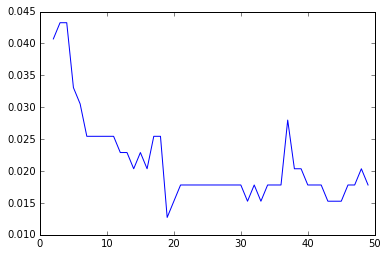

In [412]:
# find best K to use Grid Search 2:50 by 1
k = 3
knn = KNeighborsClassifier(n_neighbors=k)

k_range = range(2, 50, 1)
param_grid = dict(n_neighbors=k_range)
grid = GridSearchCV(knn, param_grid, cv=5, scoring='accuracy')
grid.fit(X, target)
grid.grid_scores_
grid_mean_scores = [result[1] for result in grid.grid_scores_] # get scores from grid.grid_scores_
# visualize results
plt.figure()
plt.plot(k_range, grid_mean_scores)

print 'best grid score', grid.best_score_ 
best_k = grid.best_params_['n_neighbors']

print 'Using K = ', best_k
# knn = KNeighborsClassifier(n_neighbors=best_k)
knn.fit(X, target)
knn.score(X, target)
preds_knn = knn.predict(X)
knn_model = grid.best_estimator_ 

print 'Accuracy for KNN model'
print accuracy_score(target, preds_knn)
# print 'KNN Confusion Matrix'
# print metrics.confusion_matrix(target, preds_knn)
rmse_knn = np.sqrt(metrics.mean_squared_error(target, preds_knn)) 
print 'KNN RMSE', rmse_knn

scores = cross_val_score(knn, X, target, cv=cvn, scoring='mean_squared_error')
rmse_knn_cv = np.mean(np.sqrt(-scores))
print 'KNN RMSE CV', rmse_knn_cv

In [413]:
logreg = LogisticRegression(C=1e9)
logreg.fit(X, target)
assorted_pred_class = logreg.predict(X)
assorted_pred_prob = logreg.predict_proba(X)[:, 1]
intercept = logreg.intercept_
logregm = zip(X,logreg.coef_[0]) # examine coeff
preds_logreg = logreg.predict(X)

logodds = logreg.intercept_
odds = np.exp(logodds)
prob = odds/(1 + odds)
prob

print 'Accuracy for Logistic Regression model'
print accuracy_score(target, preds_logreg)
print 'Logistic Regression Confusion Matrix'
print metrics.confusion_matrix(target, preds_logreg)
# print(classification_report(target, preds_logreg))
rmse_logreg = np.sqrt(metrics.mean_squared_error(target, preds_logreg)) 
print 'Log Reg RMSE', rmse_logreg

scores = cross_val_score(logreg, X, target, cv=cvn, scoring='mean_squared_error')
rmse_logreg_cv = np.mean(np.sqrt(-scores))
print 'Log Reg RMSE CV', rmse_logreg_cv


Accuracy for Logistic Regression model
0.0483460559796
Logistic Regression Confusion Matrix
[[0 0 0 ..., 1 0 0]
 [0 0 0 ..., 1 0 0]
 [0 0 0 ..., 0 0 0]
 ..., 
 [0 0 0 ..., 5 0 0]
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 3 0 0]]
Log Reg RMSE 48.4635431301
Log Reg RMSE CV 48.5745323069


In [416]:
# sort DataFrame by al
# df_book.sort(df_book., inplace=True)
# plt.scatter(target, assorted_pred_class, color = 'red')
# plt.plot(target, assorted_pred_prob, color='red')


<bound method MultinomialNB.get_params of MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)>

In [434]:
# Using default settings for NB model
# ignoring negative channels for nb. 
ignore_nb = ['hotel_cluster', 'date_time', 'srch_ci', 'srch_co',\
             'booking_clust', 'orig_destination_distance',\
             'mean_latent','median_latent', 'max_latent','min_latent']
X_nb = df_book.drop(ignore_nb, axis = 1) # features

nb = MultinomialNB()
nb.fit(X_nb, target)

# three paramaters you can set: 
# alpha=1.0, 
# class_prior=None, 
# fit_prior=True - estimates the likelihood function - counting the probability for each. 

preds_nb = nb.predict(X_nb)
print metrics.accuracy_score(target, preds_nb)
print metrics.confusion_matrix(target, preds_nb)

rmse_nb = np.sqrt(metrics.mean_squared_error(target, preds_nb)) 
print 'RMSE for NB', rmse_nb

scores = cross_val_score(nb, X_nb, target, cv=cvn, scoring='mean_squared_error')
rmse_nb_cv = np.mean(np.sqrt(-scores))
print 'CV RMSE for NB', rmse_nb_cv

# probs_nb = nb.predict_proba(X)[:, 1]
# probs_nb
# print metrics.roc_auc_score(target, probs_nb)

0.0661577608142
[[1 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 ..., 
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 [0 0 3 ..., 0 0 0]]
RMSE for NB 39.6139127898
CV RMSE for NB 41.7095118017


(41.709511801682218, 1)
Best Max Features to use 1


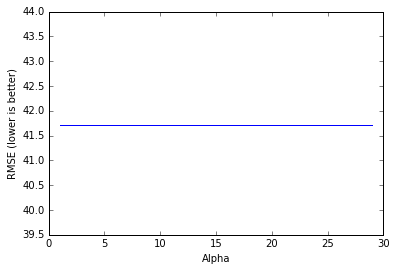

In [435]:
# Trying differnt values for Alpha 
# three paramaters you can set: 
# alpha=1.0, 
# class_prior=None, 
# fit_prior=True - estimates the likelihood function - counting the probability for each. 
MSE_scores = []
RMSE_scores = []
alpha_range = range(1,30,2)
for a in alpha_range:
    nb = MultinomialNB(alpha = a)
    nb.fit(X_nb, target)
    MSE_scores = cross_val_score(nb, X_nb, target, cv=cvn, scoring='mean_squared_error')
    RMSE_scores.append(np.mean(np.sqrt(-MSE_scores)))

plt.plot(alpha_range, RMSE_scores)
plt.xlabel('Alpha')
plt.ylabel('RMSE (lower is better)')

feature_scores = sorted(zip(RMSE_scores, alpha_range))[0]
best_alpha = feature_scores[1]

print feature_scores
print 'Best Alpha to use', best_alpha

(41.709511801682218, 1)
Best Max Features to use 1


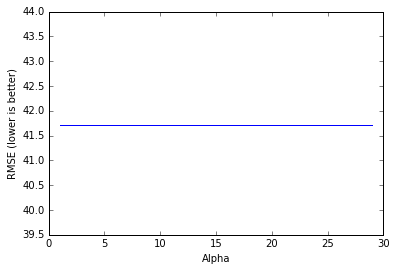

In [437]:
# Trying differnt values for Alpha, fit_prior = false
# three paramaters you can set: 
# alpha=1.0, 
# class_prior=None, 
# fit_prior=True - estimates the likelihood function - counting the probability for each. 
MSE_scores = []
RMSE_scores = []
alpha_range = range(1,30,2)
for a in alpha_range:
    nb = MultinomialNB(alpha = a, fit_prior = False)
    nb.fit(X_nb, target)
    MSE_scores = cross_val_score(nb, X_nb, target, cv=cvn, scoring='mean_squared_error')
    RMSE_scores.append(np.mean(np.sqrt(-MSE_scores)))

plt.plot(alpha_range, RMSE_scores)
plt.xlabel('Alpha')
plt.ylabel('RMSE (lower is better)')

feature_scores = sorted(zip(RMSE_scores, alpha_range))[0]
best_alpha = feature_scores[1]

print feature_scores
print 'Best Alpha to use', best_alpha

In [387]:
# Decision Tree
treeclf = DecisionTreeClassifier(max_depth=3, random_state=1)
treeclf.fit(X, target)
preds_dtree = treeclf.predict(X)
predic_proba = treeclf.predict_proba(X)
sc = treeclf.score(X,target)

# export_graphviz(treeclf, out_file='tree_titanic.dot', feature_names=features)
# At the command line, run this to convert to PNG:
#   dot -Tpng tree_titanic.dot -o tree_titanic.png

# compute the feature importances
# importaces are on a scale on 0 to 1
pd.DataFrame({'feature':features, 'importance':treeclf.feature_importances_})

print 'Mean Accuracy on Test Data and Labels', sc
rmse_dtree = np.sqrt(metrics.mean_squared_error(target, preds_dtree))
print 'RMSE DTREE', rmse_dtree

scores = cross_val_score(treeclf, X, target, cv=cvn, scoring='mean_squared_error')
rmse_dtree_cv = np.mean(np.sqrt(-scores))
print 'CV RMSE DTREE', rmse_dtree_cv

# test data 
# X_test = test[features]
# y_test = test.price
# y_pred = treereg.predict(X_test)
# y_pred

# np.sqrt(metrics.mean_squared_error(y_test, y_pred))

Mean Accuracy on Test Data and Labels 0.106870229008
RMSE DTREE 33.2571903875
CV RMSE DTREE 39.5965753619


DecisionTreeClassifier(criterion='gini', splitter='best', max_depth=None, min_samples_split=2,\
                       min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features=None, \
                       random_state=None, max_leaf_nodes=None, class_weight=None, presort=False)

Best Max Depth Score (37.943742554891251, 2)
Best Max Depth to use 2
Best Min Samples Score (32.139981412774773, 86)
Best Min Samples to use 86
Mean Accuracy on Test Data and Labels 0.0839694656489
RMSE DTREE Best Set 37.8190414767
CV RMSE DTREE Best Set 32.1399814128


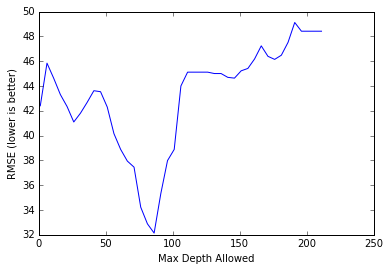

In [448]:
# Search For better settings for Decision Tree
# searching for max_depth and min_samples_leaf

# search max_depth
max_depth_range = range(1,30,1)
MSE_scores = []
RMSE_scores= []
for md in max_depth_range: 
    treeclf = DecisionTreeClassifier(max_depth=md, random_state=1)
    treeclf.fit(X, target)
    MSE_scores = cross_val_score(treeclf, X, target, cv=cvn, scoring='mean_squared_error')
    RMSE_scores.append(np.mean(np.sqrt(-MSE_scores)))

plt.plot(max_depth_range, RMSE_scores)
plt.xlabel('Max Depth Allowed')
plt.ylabel('RMSE (lower is better)')

depth_scores = sorted(zip(RMSE_scores, max_depth_range))[0]
best_depth = depth_scores[1]
print 'Best Max Depth Score', depth_scores
print 'Best Max Depth to use', best_depth


# search min_samples_leaf
min_samples_leaf_range = range(1,215,5)
MSE_scores = []
RMSE_scores= []
for msl in min_samples_leaf_range: 
    treeclf = DecisionTreeClassifier(min_samples_leaf=msl, random_state=1)
    treeclf.fit(X, target)
    MSE_scores = cross_val_score(treeclf, X, target, cv=cvn, scoring='mean_squared_error')
    RMSE_scores.append(np.mean(np.sqrt(-MSE_scores)))


plt.plot(min_samples_leaf_range, RMSE_scores)
plt.xlabel('Max Depth Allowed')
plt.ylabel('RMSE (lower is better)')

min_samp_scores = sorted(zip(RMSE_scores, min_samples_leaf_range))[0]
best_min_samp = min_samp_scores[1]
print 'Best Min Samples Score', min_samp_scores
print 'Best Min Samples to use', best_min_samp


# combine best settings discovered in two separate searches 
treeclf = DecisionTreeClassifier(max_depth=best_depth, min_samples_leaf = best_min_samp, random_state=1)
treeclf.fit(X, target)
preds_dtree = treeclf.predict(X)
# predic_proba = treeclf.predict_proba(X)
sc = treeclf.score(X,target)

# compute the feature importances
# importaces are on a scale on 0 to 1
pd.DataFrame({'feature':features, 'importance':treeclf.feature_importances_})

print 'Mean Accuracy on Test Data and Labels', sc
rmse_dtree_best_set = np.sqrt(metrics.mean_squared_error(target, preds_dtree))
print 'RMSE DTREE Best Set', rmse_dtree_best_set

scores = cross_val_score(treeclf, X, target, cv=cvn, scoring='mean_squared_error')
rmse_dtree_best_set_cv = np.mean(np.sqrt(-scores))
print 'CV RMSE DTREE Best Set', rmse_dtree_best_set_cv


In [ ]:
# Nested Search For better settings for Decision Tree
# searching for max_depth and min_samples_leaf

# search max_depth
max_depth_range = range(1,30,1)
min_samples_leaf_range = range(1,215,5)
MSE_loop1_scores = []
MSE_loop2_scores = []
RMSE_loop1_scores= []
RMSE_loop2_scores= []

for msl in min_samples_leaf_range: 
    for md in max_depth_range: 
        treeclf = DecisionTreeClassifier(max_depth=md, min_samples_leaf=msl, random_state=1)
        treeclf.fit(X, target)
        MSE_loop2_scores = cross_val_score(treeclf, X, target, cv=cvn, scoring='mean_squared_error')
        RMSE_loop2_scores.append(np.mean(np.sqrt(-MSE_scores)))
    RMSE_loop1_scores.append(min(RMSE_loop1_scores))
    

plt.plot(min_samples_leaf_range, RMSE_loop1_scores)
plt.xlabel('Min Samples allowed')
plt.ylabel('RMSE (lower is better)')

# depth_scores = sorted(zip(RMSE_loop1_scores, max_depth_range))[0]
# best_depth = depth_scores[1]
# print 'Best Max Depth Score', depth_scores
# print 'Best Max Depth to use', best_depth


min_samp_scores = sorted(zip(RMSE_scores, min_samples_leaf_range))[0]
best_min_samp = min_samp_scores[1]
print 'Best Min Samples Score', min_samp_scores
print 'Best Min Samples to use', best_min_samp


# combine best settings discovered in two separate searches 
treeclf = DecisionTreeClassifier(max_depth=best_depth, min_samples_leaf = best_min_samp, random_state=1)
treeclf.fit(X, target)
preds_dtree = treeclf.predict(X)
# predic_proba = treeclf.predict_proba(X)
sc = treeclf.score(X,target)

# compute the feature importances
# importaces are on a scale on 0 to 1
pd.DataFrame({'feature':features, 'importance':treeclf.feature_importances_})

print 'Mean Accuracy on Test Data and Labels', sc
rmse_dtree_best_set = np.sqrt(metrics.mean_squared_error(target, preds_dtree))
print 'RMSE DTREE Best Set', rmse_dtree_best_set

scores = cross_val_score(treeclf, X, target, cv=cvn, scoring='mean_squared_error')
rmse_dtree_best_set_cv = np.mean(np.sqrt(-scores))
print 'CV RMSE DTREE Best Set', rmse_dtree_best_set_cv


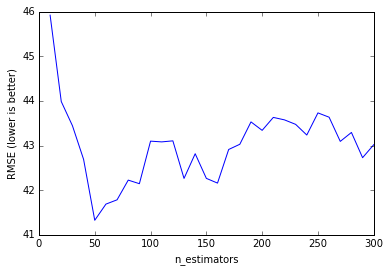

In [389]:
# Random Forest 
rfreg = RandomForestClassifier()

# Tuning n_estimators
# list of values to try for n_estimators
estimator_range = range(10, 310, 10)

# list to store the average RMSE for each value of n_estimators
RMSE_scores = []

# use 5-fold cross-validation with each value of n_estimators (WARNING: SLOW!)
for estimator in estimator_range:
    rfreg = RandomForestClassifier(n_estimators=estimator, random_state=1)
    MSE_scores = cross_val_score(rfreg, X, target, cv=5, scoring='mean_squared_error')
    RMSE_scores.append(np.mean(np.sqrt(-MSE_scores)))
    
plt.plot(estimator_range, RMSE_scores)
plt.xlabel('n_estimators')
plt.ylabel('RMSE (lower is better)')

(38.087779398158858, 14)
Best Max Features to use 14


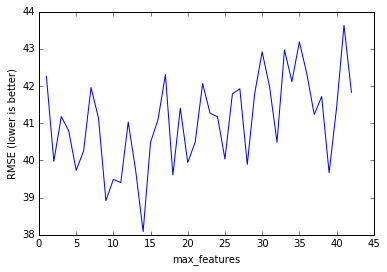

In [390]:
best_n = 175
# Tuning max Features
# list of values to try for max_features
feature_range = range(1, len(features)+1)

# list to store the average RMSE for each value of max_features
RMSE_scores = []

# use 10-fold cross-validation with each value of max_features (WARNING: SLOW!)
for feature in feature_range:
    rfreg = RandomForestClassifier(n_estimators=best_n, max_features=feature, random_state=1)
    MSE_scores = cross_val_score(rfreg, X, target, cv=10, scoring='mean_squared_error')
    RMSE_scores.append(np.mean(np.sqrt(-MSE_scores)))
    
plt.plot(feature_range, RMSE_scores)
plt.xlabel('max_features')
plt.ylabel('RMSE (lower is better)')

feature_scores = sorted(zip(RMSE_scores, feature_range))[0]
best_max_feat = feature_scores[1]

print feature_scores
print 'Best Max Features to use', best_max_feat

In [391]:
# Fitting Random Forest with best parameters
rfclass = RandomForestClassifier(n_estimators = best_n, max_features = best_max_feat, oob_score=True, random_state=1)
rfclass.fit(X, target)

# compute feature importances
pd.DataFrame({'feature':features, 'importance':rfclass.feature_importances_}).sort('importance')

# compute the out-of-bag R-squared score
rfclass.oob_score_
preds_rf = rfclass.predict(X)
rmse_rf = np.sqrt(metrics.mean_squared_error(target, preds_rf))
print 'RMSE RF', rmse_rf

scores = cross_val_score(rfclass, X, target, cv=10, scoring='mean_squared_error')
rmse_rf_cv = np.mean(np.sqrt(-scores))
print 'CV RMSE RF', rmse_rf_cv

RMSE RF 0.0
CV RMSE RF 38.0877793982


/Users/mcullen/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:7: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


In [392]:
# Reduce X to important features
# check the shape of X
# X.shape
# rfclass_imp = RandomForestClassifier(n_estimators = best_n, max_features = best_max_feat, oob_score=True, random_state=1)
# rfclass_imp.fit(X, target)
# print rfclass.transform(X, threshold='mean').shape
# print rfclass.transform(X, threshold='median').shape

# X_important = rfclass_imp.transform(X, threshold='mean')
# check the RMSE for a Random Forest that only includes important features
# rfclass_imp = RandomForestClassifier(n_estimators = best_n, max_features = best_max_feat, oob_score=True, random_state=1)
# rfclass_imp.fit(X_important, target)

# preds_rf_imp = rfclass_imp.predict(X_important)
# rmse_rf_imp = np.sqrt(metrics.mean_squared_error(target, preds_rf_imp))
# print 'RMSE RF', rmse_rf_imp

# scores = cross_val_score(rfclass_imp, X_important, target, cv=10, scoring='mean_squared_error')
# rmse_rf_imp_cv = np.mean(np.sqrt(-scores))
# print 'CV RMSE RF', rmse_rf_imp_cv


In [393]:
print 'RESULTS and SCORES SUMMARY'
print 'Null Hypothesis RMSE', rmse_null
print ''
print 'KNN RMSE', rmse_knn
print 'Log Reg RMSE', rmse_logreg
print 'NB RMSE', rmse_nb
print 'DTREE RMSE', rmse_dtree
print 'DTREE RMSE Best set', rmse_dtree_best_set
print 'Random Forest RMSE', rmse_rf
# print 'Random Forest Important Features RMSE', rmse_rf_imp

print ''
print 'CV KNN RMSE', rmse_knn_cv
print 'CV Log Reg RMSE', rmse_logreg_cv
print 'CV NB RMSE', rmse_nb_cv
print 'CV DTREE RMSE', rmse_dtree_cv
print 'DTREE RMSE Best set', rmse_dtree_best_set_cv
print 'CV Random Forest RMSE', rmse_rf_cv
# print 'CV Random Forest Important Features RMSE', rmse_rf_imp_cv

RESULTS and SCORES SUMMARY
Null Hypothesis RMSE 50.0759982223

KNN RMSE 36.3383520123
Log Reg RMSE 48.4635431301
NB RMSE 39.6139127898
DTREE RMSE 33.2571903875
Random Forest RMSE 0.0

CV KNN RMSE 43.8160964675
CV Log Reg RMSE 48.5745323069
CV NB RMSE 41.7095118017
CV DTREE RMSE 39.5965753619
CV Random Forest RMSE 38.0877793982


In [261]:
# Neural Network 
# TODO


In [ ]:
# Recomendation Engine?  


In [18]:
# Final Test Full model With completely unseen test data. 
# combination of best first classification + predicting hotel cluster. 
# df_test = pd.read_csv('../Final_Project/data/test.csv'); 